# Shap Project
## Telco Customer Churn Dataset

Usamos el dataset del siguiente link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code

### Setup

In [2]:
!pip install shap

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

import shap
shap.initjs()

### EDA

In [4]:
file_path = '/content/telco_dataset.csv'
data = pd.read_csv(file_path)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
data.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


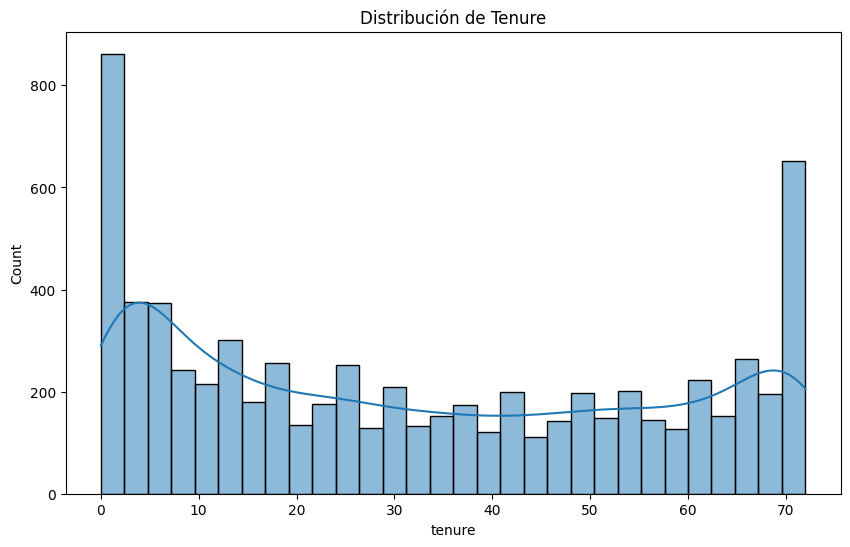

In [8]:
# Histograma de la variable 'tenure'
plt.figure(figsize=(10, 6))
sns.histplot(data['tenure'], bins=30, kde=True)
plt.title('Distribución de Tenure')
plt.show()

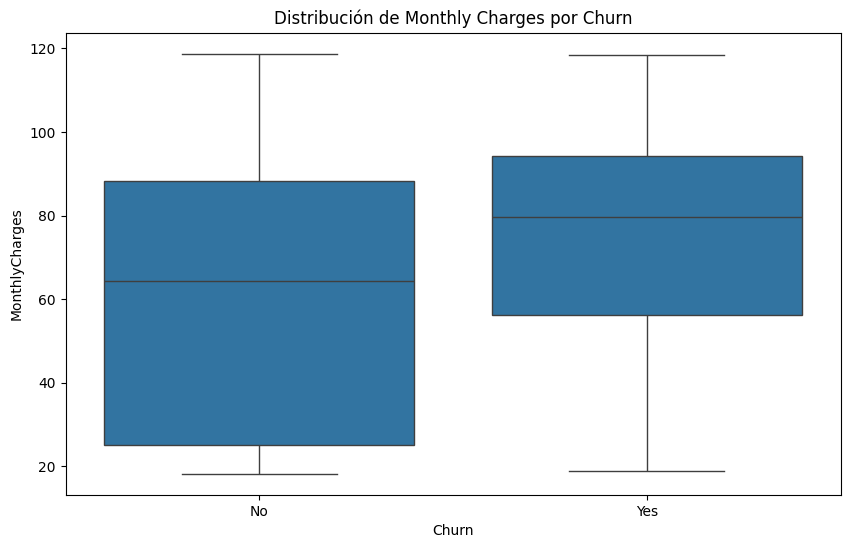

In [9]:
# Boxplot de los cargos mensuales según el churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Distribución de Monthly Charges por Churn')
plt.show()

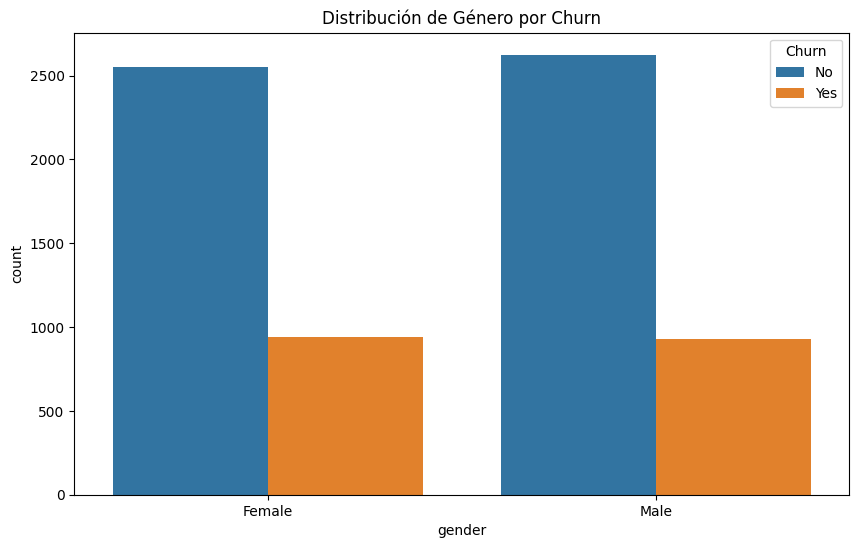

In [10]:
# Gráfico de barras de género por churn
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='Churn', data=data)
plt.title('Distribución de Género por Churn')
plt.show()

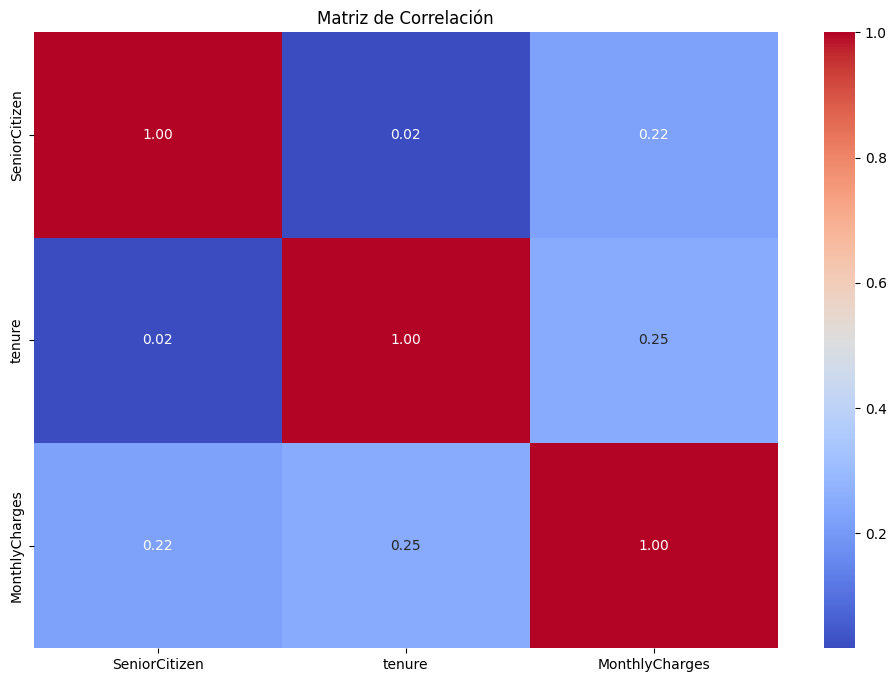

In [11]:
# Seleccionar solo las columnas numéricas
numeric_df = data.select_dtypes(include=['float64', 'int64'])

# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

### Modelo de Predicción (Random Forest)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [27]:
print(data.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [14]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

le = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = le.fit_transform(data[column])


In [15]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7941315664931378

Confusion Matrix:
 [[1406  133]
 [ 302  272]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.87      1539
           1       0.67      0.47      0.56       574

    accuracy                           0.79      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



### SHAP

Se debe usar TreeExplainer por el tipo de modelo usado basado en árboles

In [44]:
# Supongamos que tu modelo ya está entrenado
explainer = shap.Explainer(model)


In [45]:
shap_values = explainer(X_test)

In [46]:
shap_of_shap_values = np.shape(shap_values)
print(shap_of_shap_values)

(2113, 20, 2)


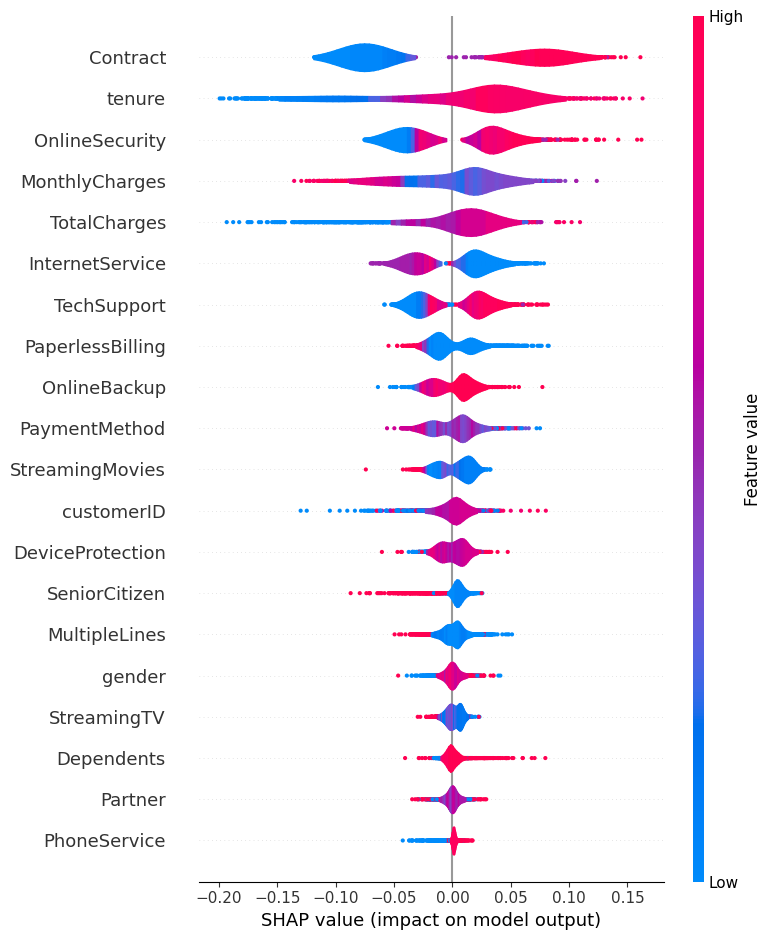

In [47]:
# Visualizar el SHAP summary plot
shap.summary_plot(shap_values[:,:,0], X_test, plot_type="violin")

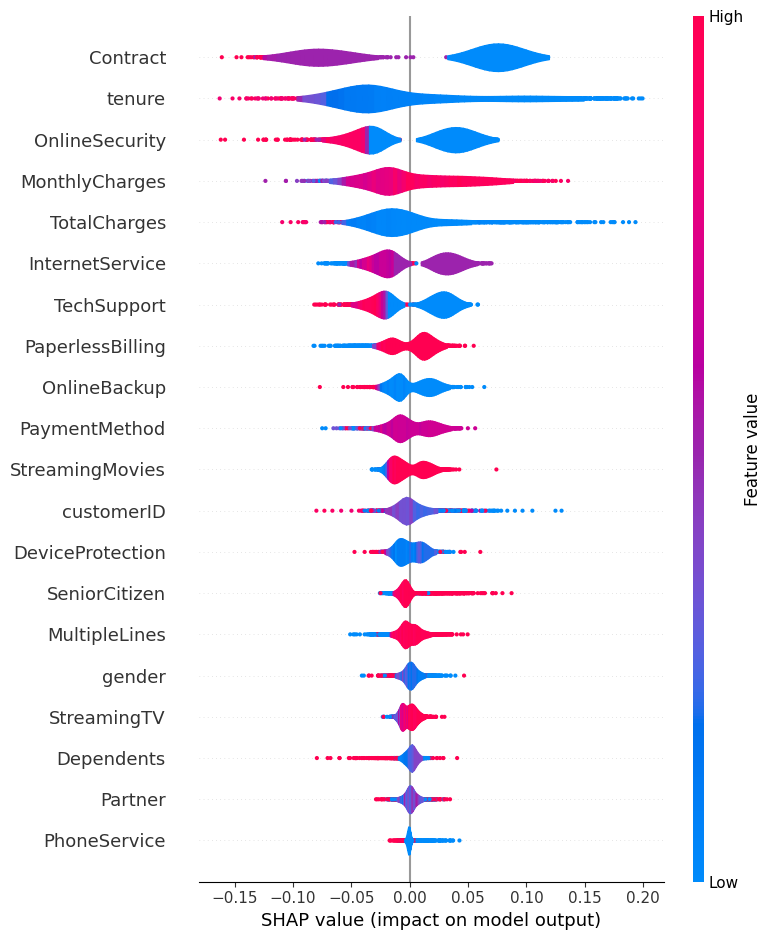

In [54]:
# Visualizar el SHAP summary plot
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="violin")

In [56]:
shapcero = shap_values[:,:,0]
shapuno = shap_values[:,:,1]

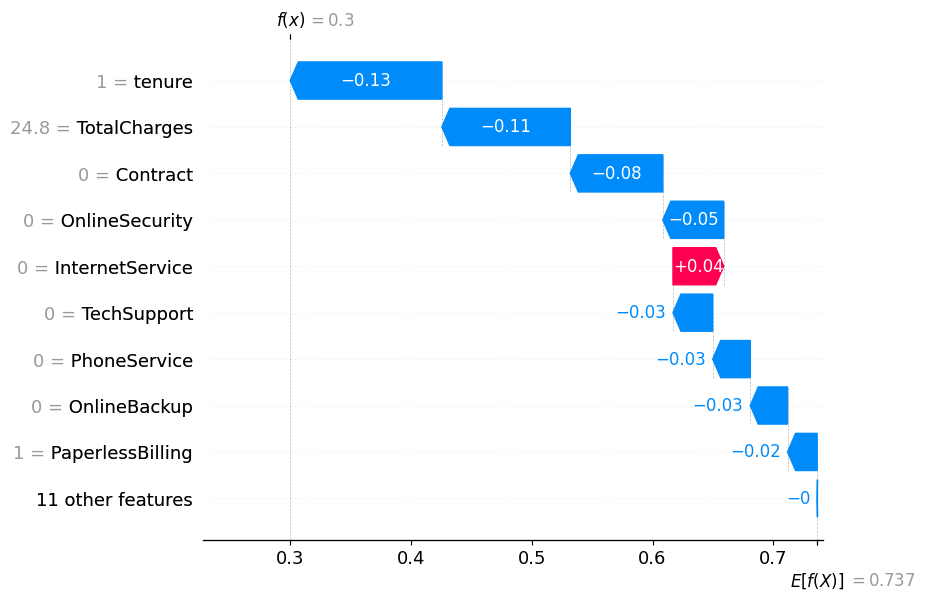

In [57]:
# Ahora puedes generar el waterfall plot
shap.plots.waterfall(shapcero[0])

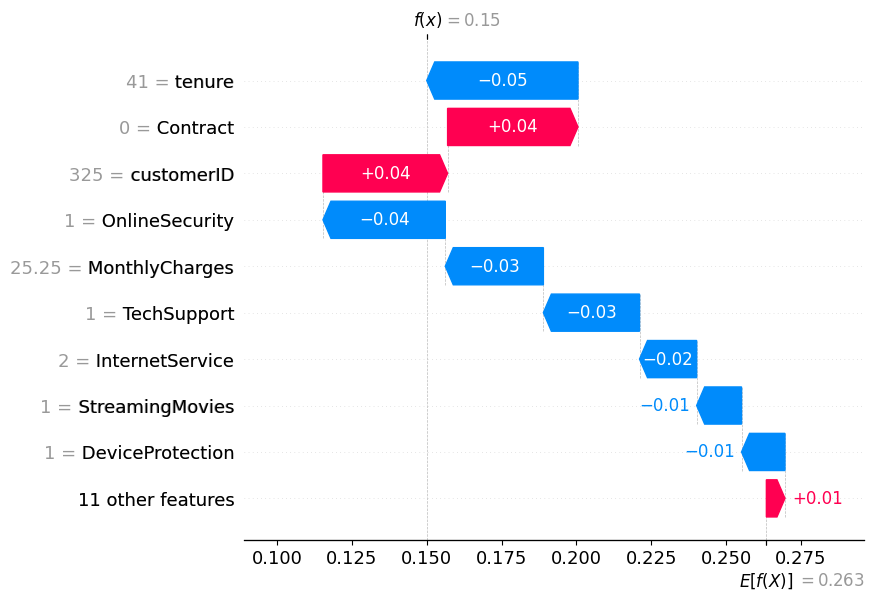

In [58]:
# Cascada para lals variables
shap.plots.waterfall(shapuno[1])

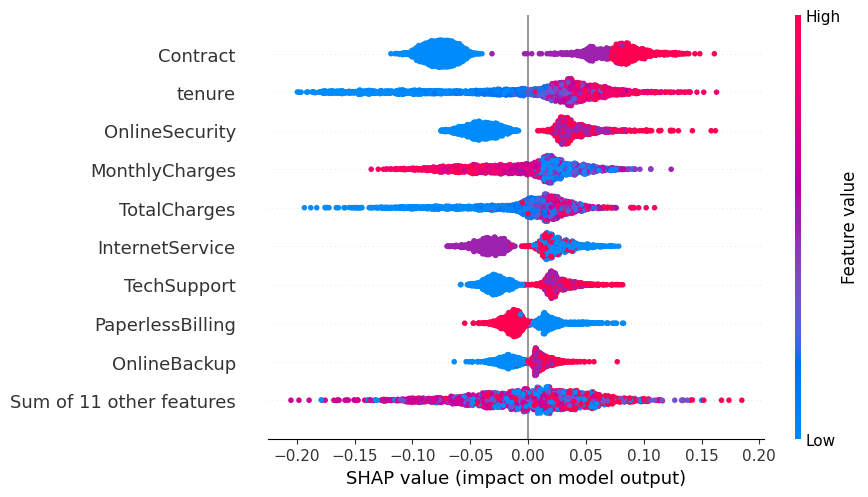

In [60]:
# Grafica de abejas
shap.plots.beeswarm(shapcero)

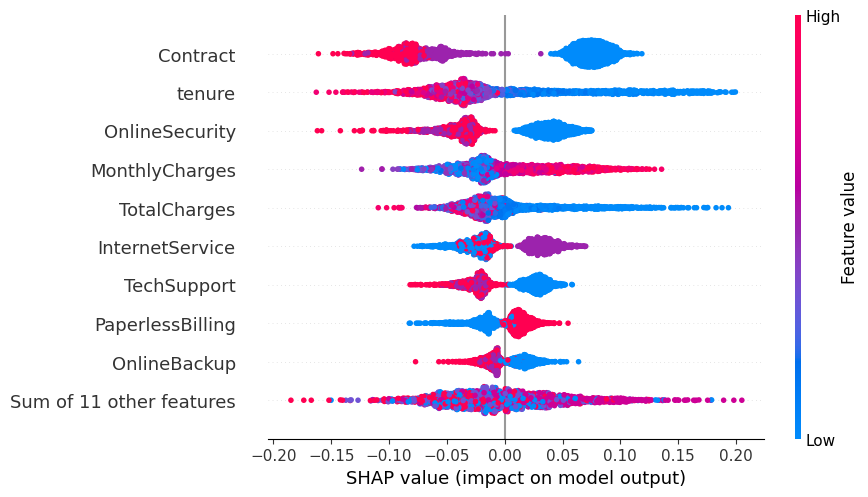

In [65]:
# Grafica de abejas
shap.plots.beeswarm(shapuno)

In [63]:
shap.initjs()

shap.plots.force(shapcero[0:10])

In [64]:
shap.initjs()

shap.plots.force(shapuno[0:10])